Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarios públicos registrados en el ámbito de la Oficina Anticorrupción.
Fuente: https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos

In [7]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
import numpy as np
import fuzzywuzzy
import seaborn as sns

from fuzzywuzzy import process
from os import path
from PIL import Image
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter

In [8]:
data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print('Cantidad de registros cargados: {}'.format(len(data)))

Cantidad de registros cargados: 3928


In [9]:
# clean and unify features
data["funcionario_nombre"] = data["funcionario_nombre_completo"].apply(str.title) + " " + data["funcionario_apellido_completo"].apply(str.title)
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [10]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print(string_to_match+" string done!")

In [11]:
# I used this to check similar roles and to determine the min_ratio I should use to replace what I want to be replaced
#matches = fuzzywuzzy.process.extract("Agustin Dellagiovanna", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
#print(matches)

df = data["funcionario_nombre"].unique()
df.sort()
print("Cantidad de nombres de funcionarixs - antes de limpieza: "+str(len(df)))

replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Alberto Angel Fernadez", min_ratio = 0)
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Agustin Dellagiovanna")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Alberto Jorge Triaca")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Carlos Vicente Ruá")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Cristina E. Fernández O Néstor C. irchner")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Cristián Roberto Dellepiane Rawson")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Damián Eduardo Arabia")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Dante Sica")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Fernando Félix Grasso")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Gustavo José Santos")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="José Lino Salvador Barañao")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Marcelo Gabriel Suárez Salvia")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Maria Inés Baque")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Marta Gabriela Michetti")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="María Eugenia Bielsa")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="María Lara González Carvajal")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Ramón Lanús")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Ramón María Lanús")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Ricardo Agustín Campero")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Roberto Salvarezza")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Rogelio Frigerio")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Santiago Tomás Bellomo")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Germán Carlos Garavano", min_ratio=84)
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Matías Daniel Lammens Núñez", in_ratio=68)
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Mauricio Macri")
replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match="Patricia Bullrich", min_ratio=75)

df = data["funcionario_nombre"].unique()
df.sort()
print("Cantidad de nombres de funcionarixs - después de limpieza: "+str(len(df)))

Cantidad de nombres de funcionarixs - antes de limpieza: 366
Alberto Angel Fernadez string done!
Agustin Dellagiovanna string done!
Alberto Jorge Triaca string done!
Carlos Vicente Ruá string done!
Cristina E. Fernández O Néstor C. irchner string done!
Cristián Roberto Dellepiane Rawson string done!
Damián Eduardo Arabia string done!
Dante Sica string done!
Fernando Félix Grasso string done!
Gustavo José Santos string done!
José Lino Salvador Barañao string done!
Marcelo Gabriel Suárez Salvia string done!
Maria Inés Baque string done!
Marta Gabriela Michetti string done!
María Eugenia Bielsa string done!
María Lara González Carvajal string done!
Ramón Lanús string done!
Ramón María Lanús string done!
Ricardo Agustín Campero string done!
Roberto Salvarezza string done!
Rogelio Frigerio string done!
Santiago Tomás Bellomo string done!
Germán Carlos Garavano string done!


TypeError: replace_matches_in_column() got an unexpected keyword argument 'in_ratio'

In [55]:
#since there are several roles with similar names / descriptions.. we need to unify them
data["funcionario_funcion"] = data["funcionario_funcion"].str.lower()
data["funcionario_funcion"] = data["funcionario_funcion"].str.strip()

def cleanTxt(text):
 text = text.replace("registro de obsequios- señor presidente de la nación",'señor presidente de la nación')
 text = text.replace("hija de la señora de macri", "hija de la señora primera dama, srita valentina barbier")
 text = text.replace("hija del presidente de la nación de la nación, srita. antonia macri", "hija del presidente de la nación, srita. antonia macri")
 text = text.replace("vicepreseidencia",'vicepresidente')
 return text

# Clean political roles
data["funcionario_funcion"] = data.funcionario_funcion.apply(cleanTxt)

In [56]:
df = data["funcionario_funcion"].unique()
df.sort()
print(df)

['abogada de 5 ta' 'abogado dictaminador' 'administrador' 'administrativo'
 'agente de prensa y difusion' 'analista' 'analista de asuntos tecnicos'
 'analista de recaudacion'
 'analista de revision, recursos e impugnaciones'
 'analista en materia de conflictos de intereses'
 'analista principal de la coordinación de políticas de integridad'
 'asesor' 'asesor de gabinete' 'asesor presidencia y vicepresidencia'
 'asesora' 'asesoria juridica' 'asistente ceremonial' 'becario a1 p'
 'canciller' 'consejero' 'consejero de embajada' 'coordinador'
 'coordinador de control de gestión'
 'coordinador de relaciones institucionales con depandencia directa del ministerio de produccion'
 'coordinador de relaciones institucionales con dependencia directa del ministerio de produccion'
 'coordinador del programa de reconversión de áreas tabacalera (prat y del fondo especial del tabaco (fet)'
 'coordinador general' 'coordinador general de asuntos presidenciales'
 'coordinadora' 'coordinadora con organizac

In [66]:
# I used this to check similar roles and to determine the min_ratio I should use to replace what I want to be replaced
#df = data["funcionario_funcion"].unique()
#matches = fuzzywuzzy.process.extract("presidente", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
#print(matches)

[('Presidente', 100), ('Vicepresidente', 83), ('Presidente - Aabe', 80), ('Señor Presidente Y Señora', 61), ('Gerente', 59), ('Presidente Del Directorio', 57), ('Vicepresidente De La Nación', 56), ('Asesor De Gabinete', 50), ('Subgerente', 50), ('Presidencia De La Nación', 48)]


In [12]:
df = data["funcionario_funcion"].unique()
df.sort()
print("Cantidad de roles de funcionarixs - antes de limpieza: "+str(len(df)))

replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="presidente de la nación", min_ratio = 88)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="presidencia de la nación", min_ratio=88)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="vicepresidente de la nación", min_ratio = 95)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="jefe de gabinete de ministros")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="hija del señor presidente, srita antonia macri", min_ratio = 64)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="directora nacional de ética pública")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministra de relaciones exteriores y culto", min_ratio = 85)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de producción y trabajo", min_ratio = 80)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de turismo y deportes")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de turismo")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretaría de ética pública transparencia y lucha contra la corrupción")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretaria de relaciones políticas y parlamentarias")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario de economía social")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario de gobierno de energia")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario de seguridad interior")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario general de la presidencia de la nación", min_ratio = 80)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="señora primera dama", min_ratio = 65)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="subsecretario de política exterior")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="subsecretario", min_ratio = 88)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="coordinador de relaciones institucionales con dependencia directa del ministerio de produccion")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="coordinador/a general")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="titular", min_ratio = 70)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="hija de la señora primera dama, srita valentina barbier", min_ratio = 62)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de educación, cultura, ciencia y tecnología", min_ratio=85)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de agricultura, ganadería y pesca de la nación", min_ratio=85)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministra de seguridad de la nación")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="jefa de gabinete")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="jefa del dpto de priv, e inmun, acred. y guía diplo", min_ratio=82)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministra de seguridad", min_ratio=78)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="presidente - aabe")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario de agricultura, ganadería y pesca")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="secretario de coordinación de políticas públicas", min_ratio=79)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="supervisor de fiscalización")
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="ministro de educación y deportes de la nación", min_ratio=84)
replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match="vicepresidente")

df = data["funcionario_funcion"].unique()
df.sort()
print("Cantidad de roles de funcionarixs - después de limpieza: "+str(len(df)))

Cantidad de roles de funcionarixs - antes de limpieza: 365
presidente de la nación string done!
presidencia de la nación string done!
vicepresidente de la nación string done!
jefe de gabinete de ministros string done!
hija del señor presidente, srita antonia macri string done!
directora nacional de ética pública string done!
ministra de relaciones exteriores y culto string done!
ministro de producción y trabajo string done!
ministro de turismo y deportes string done!
ministro de turismo string done!
secretaría de ética pública transparencia y lucha contra la corrupción string done!
secretaria de relaciones políticas y parlamentarias string done!
secretario de economía social string done!
secretario de gobierno de energia string done!
secretario de seguridad interior string done!
secretario general de la presidencia de la nación string done!
señora primera dama string done!
subsecretario de política exterior string done!
subsecretario string done!
coordinador de relaciones institucional

In [60]:
def make_wordcloud(data, filename):
    wc = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    wc.to_file(path.join(d, filename+".png"))

In [61]:
gifts_by_value = data[["obsequio_valor_estimado","obsequio_tipo"]].groupby("obsequio_valor_estimado").count().sort_values("obsequio_tipo", ascending=False)
print("Valor aproximado de 4 módulos: $4.000")
print(gifts_by_value)

Valor aproximado de 4 módulos: $4.000
                                                    obsequio_tipo
obsequio_valor_estimado                                          
Inferior a 4 módulos.                                        3697
Superior a 4 módulos o imposibilidad de determi...            164
Inferior a 4 módulos pero con valor institucion...             67


                                                                            0
funcionario_nombre            funcionario_funcion                            
Mauricio Macri                Presidente De La Nación                    1496
Alberto Angel Fernandez       Presidente De La Nación                     176
Germán C. Garavano            Ministro                                     97
Rogelio Frigerio              Ministro                                     93
Jorge Faurie                  Ministro De Relaciones Exteriores Y Culto    84
Susana Malcorra               Ministra De Relaciones Exteriores Y Culto    64
Alberto Jorge Triaca          Ministro                                     56
Marcos Peña                   Jefe De Gabinete De Ministros                52
Marcelo Gabriel Suarez Salvia Director Nacional De Ceremonial              49
Mauricio Macri                Señora Primera Dama                          42


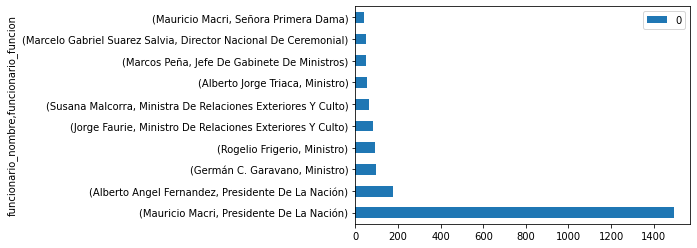

In [265]:
# we converted roles to downcase to clean and unify them.. now we convert them to CamelCase
data["funcionario_funcion"] = data["funcionario_funcion"].str.title()
gifts_received_by_role = pd.DataFrame(data[["funcionario_nombre","funcionario_funcion"]].value_counts()) #usin normalize=True repalce values with percentage

#total_gifts = gifts_received_by_role.sum()
#porcentaje_obsequios = [round(value / total_gifts * 100, 2) for value in gifts_received_by_role]
print(gifts_received_by_role.head(10))
gifts_received_by_role.head(10).plot(kind = 'barh')
plt.show()

#print(gifts_received_by_role.head(20))

In [ ]:
# Al ver estos números, nos surgió la intriga de quienes eran las personas que ocupaban cargos de ministros sin mayor detalle.
# Según Wikipedia:
# Germán Garavano se desempeñó como  ministro de Justicia y Derechos Humanos de la República Argentina desde el 10 de diciembre de 2015 hasta el 9 de diciembre de 2019
# Rogelio Frigerio ocupó el cargo de Ministro del Interior, Obras Públicas y Vivienda del gobierno de Mauricio Macri desde el 10 de diciembre de 2015 hasta el 10 de diciembre de 2019.
# Alberto Jorge Triaca fue nombrado ministro de Trabajo en 2015 por Mauricio Macri,​ cargo que ocupó hasta 2018 cuando fue degradado a secretario de Trabajo del ministerio de Producción tras una reestructuración del gabinete.

Lxs 20 funcionarixs que más regalos recibieron


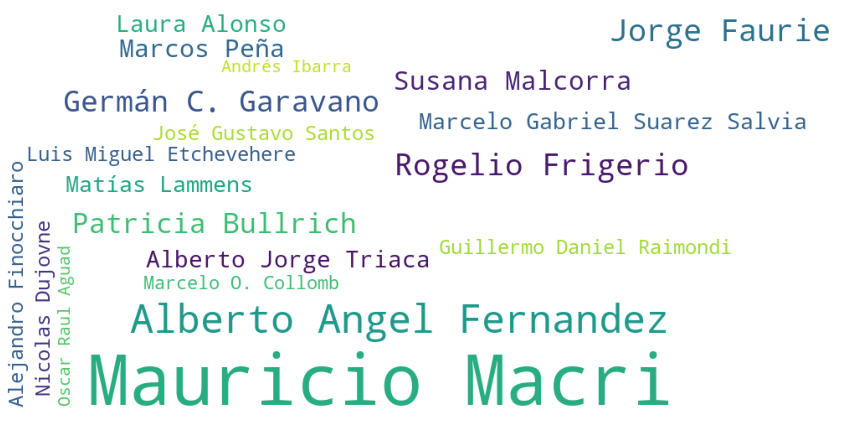

NameError: name 'd' is not defined

In [197]:
print("Lxs 20 funcionarixs que más regalos recibieron")
gift_by_func_counter = Counter(data.funcionario_nombre)
make_wordcloud(dict(gift_by_func_counter.most_common(20)), "roles_more_received_gifts_wordcloud")

In [167]:
gifts_by_date = data[["obsequio_fecha_registro"]].value_counts()
print("Días con más regalos:")
print(gifts_by_date.head(5))
# print("Día con más regalos: {} {}".format(gifts_by_date.idxmax()[0], gifts_by_date.head(1).values))
print(data.loc[(data["obsequio_fecha_registro"]=="2018-11-16") & (data["obsequio_tipo"]=="Otros"), ["obsequio_descripcion", "obsequio_valor_estimado"]].head(10))

#TODO tiene algo que ver la fecha con la cantidad de regalos??

Días con más regalos:
obsequio_fecha_registro
2018-11-16                 69
2017-08-24                 64
2019-01-17                 52
2018-09-27                 47
2019-11-27                 45
dtype: int64
                                   obsequio_descripcion  \
2199            un (1) escultura de un pajaro de madera   
2205                 una (1) lapicera de madera grabada   
2207        una (1) maqueta de una bomba oleohidráuilca   
2209                                        un (1) mate   
2213                 una (1) pintura en oleo de bebidas   
2216                              un (1) móbil colgante   
2217      una (1) pintura "la bandera argentina de hoy"   
2218  una (1) bandeja de plata -un (1) libro "200 - ...   
2219                          un (1) cuadro de una coya   
2227       un (1) cuadro en oleo: "esfuerzo al trabajo"   

     obsequio_valor_estimado  
2199   Inferior a 4 módulos.  
2205   Inferior a 4 módulos.  
2207   Inferior a 4 módulos.  
2209   Inferior a

Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)
Valor de módulo: https://desafiospublicos.argentina.gob.ar/normativa/nacional/decreto-1030-2016-265506/texto
                                   obsequio_descripcion
obsequio_tipo                                          
Objetos en general                                   54
Otros                                                48
Obras de arte                                        22
Joyería y relojería                                  15
Artesanías (productos regionales)                    10
Alimentos                                             6
Libros                                                4
Indumentaria                                          3
Electrónicos                                          1
Mobiliario                                            1


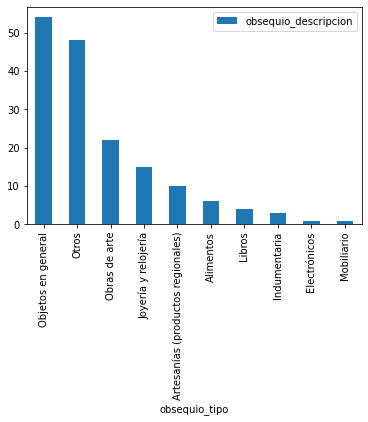

In [168]:
expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]

print("Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)")
print("Valor de módulo: https://desafiospublicos.argentina.gob.ar/normativa/nacional/decreto-1030-2016-265506/texto")
expensive_gifts_by_type = expensive_gifts[["obsequio_tipo", "obsequio_descripcion"]].groupby("obsequio_tipo").count().sort_values("obsequio_descripcion", ascending=False)

print(expensive_gifts_by_type)
expensive_gifts_by_type.plot(kind = 'bar')
plt.show()

In [169]:
print("Obsequios con un valor mayor a 4 módulos ($4.000)")
expensive_gifts["obsequio_descripcion"]
#TODO se podría averiguar valor de los regalos? aproximado?

Obsequios con un valor mayor a 4 módulos ($4.000)


28      bolígrafo - montblanc - pix rollerball blue - ...
65                                              alfombras
104                  alfombra fbmi - modelo sultan mamluk
107      pañuelo hermes 90cm mythiques phoenix coloriages
142     "una (1) tetera de porcelana pintada-cuatro (4...
                              ...                        
3683                                        4 cajas de té
3702                                     bandeja de plata
3703                                        4 cajas de té
3704    caja de lata que contiene: una mascarilla de s...
3709    un mate de calabaza con detalle de alpaca y un...
Name: obsequio_descripcion, Length: 164, dtype: object

In [170]:
# Create a function to clean gift descriptions
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# Clean gift descriptions
expensive_gifts["clean_obsequio_descripcion"] = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

#print(expensive_gifts.obsequio_descripcion.unique())
print(expensive_gifts.clean_obsequio_descripcion.unique())

['bolígrafo, montblanc, pix rollerball blue, serie 114809 origen: alemania'
 'alfombras' 'alfombra fbmi, modelo sultan mamluk'
 'pañuelo hermes 90cm mythiques phoenix coloriages'
 'una tetera de porcelana pintada,cuatro tazas sin asa de porcelana pintada,una caramelera de porcelana'
 'plato de porcelana, elaborado con la técnica de porcelana tierna, material pasta tierna.'
 'cafetera clasica de la hospitaridad arabe presentada en base caoba'
 'cuadro de estilo abstracto'
 'un juego de té de porcelana pintada a mano compuesto por una tetera, un plato y cinco tacitas'
 'un cuadro de singapur en acuarela'
 'un centro de mesa cuadrado de vidrio con flores'
 'una fuente de metal plateado con la casa blanca grabada'
 'un cuadro de la universidad de pensilvania'
 'un cuadro de vidrio con la imagen de un caballo'
 'una billetera color bordeaux salvatore ferragamo'
 'un marco de cristal con el escudo de la república italiana'
 'una fotografía del árbol jacaranda del autor matías costa'
 'una li

In [171]:
#tokenize gifts descriptions and remove spanish stopwords
nlp = Spanish(path=None)
#TODO consumir api de ML para obtener precio random de regalos?

for i in range(len(expensive_gifts)):
  gift = expensive_gifts[["clean_obsequio_descripcion"]].iloc[i][0]
  doc = nlp(gift)
  #tokens = [token.text for token in doc if not token.is_stop]
  tokens = [token for token in doc]
  print(tokens)

[bolígrafo, ,, montblanc, ,, pix, rollerball, blue, ,, serie, 114809, origen, :, alemania]
[alfombras]
[alfombra, fbmi, ,, modelo, sultan, mamluk]
[pañuelo, hermes, 90, cm, mythiques, phoenix, coloriages]
[una, tetera, de, porcelana, pintada, ,, cuatro, tazas, sin, asa, de, porcelana, pintada, ,, una, caramelera, de, porcelana]
[plato, de, porcelana, ,, elaborado, con, la, técnica, de, porcelana, tierna, ,, material, pasta, tierna, .]
[cafetera, clasica, de, la, hospitaridad, arabe, presentada, en, base, caoba]
[cuadro, de, estilo, abstracto]
[un, juego, de, té, de, porcelana, pintada, a, mano, compuesto, por, una, tetera, ,, un, plato, y, cinco, tacitas]
[un, cuadro, de, singapur, en, acuarela]
[un, centro, de, mesa, cuadrado, de, vidrio, con, flores]
[una, fuente, de, metal, plateado, con, la, casa, blanca, grabada]
[un, cuadro, de, la, universidad, de, pensilvania]
[un, cuadro, de, vidrio, con, la, imagen, de, un, caballo]
[una, billetera, color, bordeaux, salvatore, ferragamo]
[un,

In [172]:
stop_words = [token.text for token in doc if token.is_stop]
STOP_WORDS.update(stop_words)
print(STOP_WORDS.intersection(stop_words))

{'de', 'con', 'un', 'una'}


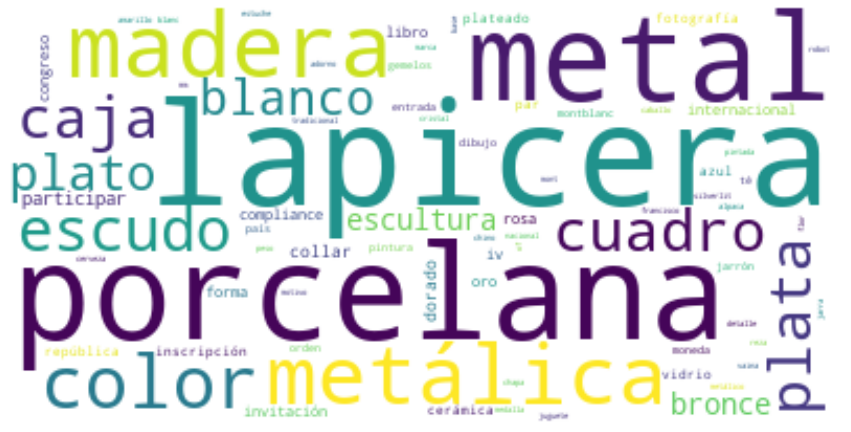

In [173]:
# word cloud visualization
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

allWords = ' '.join(expensive_gifts.clean_obsequio_descripcion)

wordCloud = WordCloud(background_color="white", random_state=21, stopwords=STOP_WORDS, collocations=False)

## uncomment to mask the generated wordcloud in a gift contour
#gift_mask = np.array(Image.open(path.join(d, "gift_mask.png")))
#wordCloud = WordCloud(background_color="white", random_state=21, stopwords=STOP_WORDS, mask=gift_mask, contour_width=2, contour_color="steelblue", collocations=False)

wordCloud.generate(allWords)

#show
plt.figure(figsize=(15,8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
## uncomment to mask the generated wordcloud in a gift contour
#plt.imshow(gift_mask, cmap=plt.cm.gray, interpolation="bilinear")
#plt.axis("off")
plt.show()

#store to file
wordCloud.to_file(path.join(d, "christmas_for_politicians.png"))

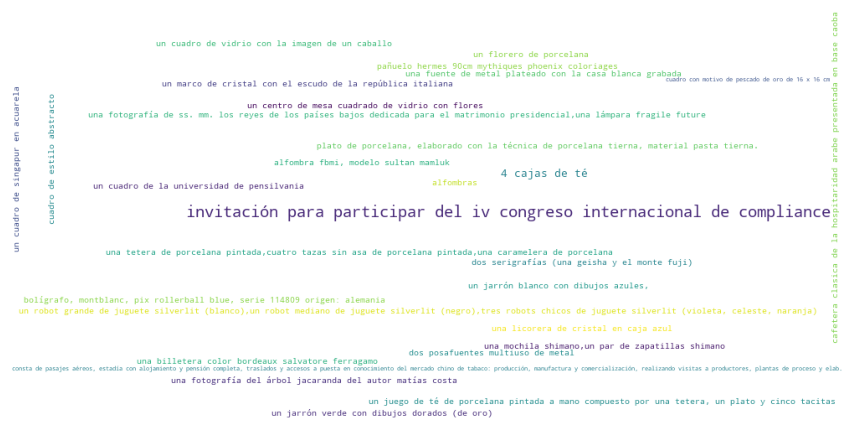

In [174]:
#generate wordCloud from full gift description
word_could_dict = Counter(expensive_gifts.clean_obsequio_descripcion)
make_wordcloud(dict(word_could_dict.most_common(30)), "gifts_wordCloud_from_frequencies")